# Юдин Артём БВТ2101

Работа аналогична предыдущей за исключением forward и backward

In [1]:
# основная библиотека, которой будем пользоваться
import torch

# фреймворк для скачивания датастеа
from torchvision import datasets
from torchvision.transforms import ToTensor

# отрисовка цифр и графиков
import matplotlib.pyplot as plt

В качестве данных для оценки и обучения нашей модели возьмём MNIST - классический датасет с распознанием рукописных цифр

In [2]:
train_data = datasets.MNIST(
    root="data", train=True, download=True, transform=ToTensor(), target_transform=None
)

test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:01<00:00, 6038776.09it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 159195.94it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:50<00:00, 32709.30it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6661024.04it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Зададим главный параметр  модели, который и будет обучаться - матрица весов. Его инициализируем случайно. Размер матрицы должен быть такой, чтобы при умножение входного вектора на неё мы получали вектор размера равный количеству классов

In [3]:
img_size = len(train_data[0][0].flatten())
num_classes = 10
weights = torch.rand(img_size, num_classes)

Создадим функцию активации. Для задачи классфикации с несколькими классами используют softmax. Она превращает наши случайные значения классов в распределение вероятностей.

$$ O_i = \frac{e^{z_{i}}}{\sum_{j}^{}e^{z_{j}}} $$ 

In [4]:
def softmax(y_pred):
    return torch.exp(y_pred) / torch.sum(torch.exp(y_pred))

Все операции с моделью можно разделить на 2 условные части:
+ прямое распространение, когда мы считаем предсказания
+ обратное распространение, когда мы изменяем веса

Создадим обе функции. При том для прямого распространения добавим флаг, чтобы применять или не применять обратное распространение в зависимости от того мы модель обучаем или оцениваем.

Прямое распространение можно представить как
$$ y_{j} = \sum_{i}^{}x_{i}w_{ji}$$

<div class="alert alert-block alert-info">
<b>Новая часть ниже</b>
</div>

Изменения в этой лабе:
+ дельта-правило заменяем на градиент
+ обучение по бачам

Первое необходимо, так как градиент буквально сердце глубокого обучения уже многие годы.

Второе нужно для большей стабильности, потому что мы сначала накапливаем изменения весов, и только потом изменяем их. Это повышает стабильности модели и меньше портит веса единичными плохими экземплярами

In [5]:
def forward(
    data, weights, train=True, lr=1e-3, img_size=784, num_classes=10, batch_size=16
):
    # метрика отслеживания обучения модели
    acc = 0

    # переменные для аккумуляции изменений по бачам
    dw = torch.zeros(img_size, num_classes)
    batch_count = 0

    for features, target in data:
        # так как у нас в картинке ещё есть параметр канала, избавимся от него
        # [1, 28, 28] -> [28, 28]
        features = torch.squeeze(features)

        # сожмём матрицу в вектор [28, 28] -> [784]
        features = torch.flatten(features)

        # нормируем значения из диапозона 0-255 в диапозон 0-1,
        # чтобы в том числе не сломать softmax большой степенью е
        features = features / 255

        # вычисляем предсказания
        y_pred = features @ weights.float()
        y_soft = softmax(y_pred)

        # если мы в обучение
        if train:
            batch_count += 1
            dw += backward(y_soft, target, features, weights, num_classes)

            # мы записали изменения с бача
            if batch_count == batch_size:
                # изменяем на минус градиент, потому что градиент направляет
                # на максимизацию потерь
                weights -= lr * dw

                # обнуляем аккумуляцию
                dw = torch.zeros(img_size, num_classes)
                batch_count = 0

        acc += target == torch.argmax(y_soft)

    # у нас остались незаписанные изменения, потому что датасет не поделился
    # на бач без остатка
    if batch_count != 0:
        weights -= lr * dw

    # если мы не прервали цикл после получения dw
    else:
        return acc, weights, True

    # если прервали
    return acc, weights, False


def backward(y_soft, target, features, weights, num_classes):
    # кодируем правильное значение класса
    true_tensor = torch.zeros(num_classes)
    true_tensor[target] = 1

    # считаем, в каких классах и насколько мы ошиблись
    dE_dt = y_soft - true_tensor

    # передаём дальше градиент по влиянию пикселей на ошибку
    dE_dW = features.unsqueeze(dim=0).T @ dE_dt.unsqueeze(dim=0)

    return dE_dW

In [7]:
train_acc = []
test_acc = []

for epoch in range(10):
    print("epoch", epoch)
    tr_acc, weights, still_training = forward(
        train_data, weights, True, 5e-2, img_size, num_classes
    )

    tr_acc = (tr_acc.float() / len(train_data)).item()
    train_acc.append(tr_acc)

    if not still_training:
        print("Веса больше не обновляются")
        break

    te_acc, weights, _ = forward(test_data, weights, False, 5e-2, img_size, num_classes)

    te_acc = (te_acc.float() / len(test_data)).item()
    test_acc.append(te_acc)
    print(f"Train accuracy = {tr_acc:.4f}, test accuracy = {te_acc:.4f}")

epoch 0
Train accuracy = 0.4990, test accuracy = 0.6531
epoch 1
Train accuracy = 0.6727, test accuracy = 0.6896
epoch 2
Train accuracy = 0.6979, test accuracy = 0.7070
epoch 3
Train accuracy = 0.7115, test accuracy = 0.7183
epoch 4
Train accuracy = 0.7200, test accuracy = 0.7278
epoch 5
Train accuracy = 0.7274, test accuracy = 0.7356
epoch 6
Train accuracy = 0.7329, test accuracy = 0.7424
epoch 7
Train accuracy = 0.7379, test accuracy = 0.7484
epoch 8
Train accuracy = 0.7423, test accuracy = 0.7532
epoch 9
Train accuracy = 0.7462, test accuracy = 0.7566


Отрисуем графики точности обучения

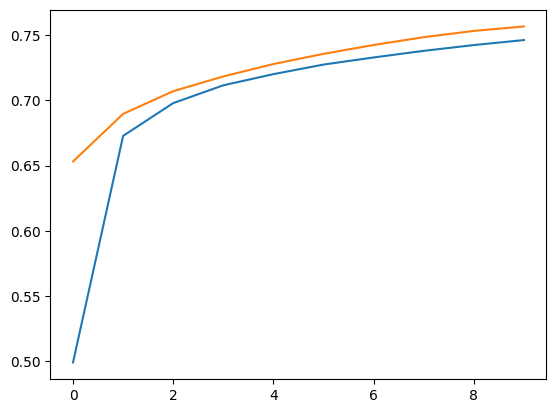

In [8]:
plt.plot(train_acc)
plt.plot(test_acc)

Также отрисуем первые 4 цифры в датасете и посотрим на предсказания мдели

tensor([0.1153, 0.0794, 0.0954, 0.1376, 0.0682, 0.1101, 0.0949, 0.0965, 0.1142,
        0.0885])
tensor(3)
tensor([0.2809, 0.0559, 0.0837, 0.0919, 0.0645, 0.0956, 0.0912, 0.0742, 0.0890,
        0.0732])
tensor(0)
tensor([0.1020, 0.0661, 0.1026, 0.1034, 0.1311, 0.0896, 0.1037, 0.0929, 0.0992,
        0.1095])
tensor(4)
tensor([0.0743, 0.1571, 0.1184, 0.1047, 0.0845, 0.0827, 0.0815, 0.0818, 0.1336,
        0.0813])
tensor(1)


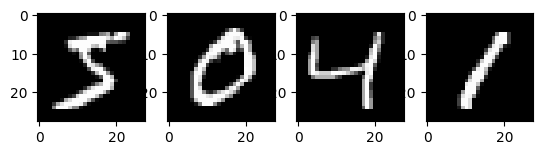

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=4)

for i in range(4):
    features, target = train_data[i]
    features = torch.squeeze(features)

    ax[i].imshow(features, cmap="gray")

    features = torch.flatten(features)
    features = features / 255

    y_pred = features @ weights.float()
    y_soft = softmax(y_pred)
    label = torch.argmax(y_soft, axis=0)

    print(y_soft)
    print(label)

## Вывод
В ходе проделанной работы мы познакомились с градиентным спуском и обучением по бачам, обучили с помощью 
этих техник простой перцептрон и получили достаточно хороший результат аналогичный тому, который получили в прошлой лабораторной.